## Library

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

## Load Data

In [2]:
path='/home/zero/fastai/data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [3]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [4]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## user and item mapping to unique id

In [7]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

## define for the net

In [9]:
n_factors = 50

In [14]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [34]:
val_idxs = get_cv_idxs(len(ratings))
data = ColumnarModelData.from_data_frame(path = path, #path to save model parameter
                                         val_idxs = val_idxs, #id of validation set
                                         df = x, #independence variable
                                         y = y, #dependence variable
                                         cat_flds = ['userId', 'movieId'], #categorycal variable
                                         bs = 64) #batch size

In [25]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

### Mini net

In [39]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        self.nh = nh
        (self.u, self.m) = [get_emb(*o) for o in [(n_users, n_factors), (n_movies, n_factors)]] #embedding layer
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = torch.cat([self.u(users),self.m(movies)], dim=1) #concat embedding layer
        x = self.drop1(x) #drop out embedding layer
        x = self.lin1(x) #add linear layer
        x = F.relu(x) #add relu layer
        x = self.drop2(x) #dropout relu layer
        x = self.lin2(x) #linear 2
        x = F.sigmoid(x) * (max_rating-min_rating+1) + min_rating-0.5 #output use non linear function for easy to train
        return x

In [40]:
#n_users number of unique user

wd=1e-5
model = EmbeddingNet(n_users, n_movies) #.cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [44]:
bm = BasicModel(model, 'binary_classifier')

In [45]:
#find learning rate
learn = StructuredLearner(data, bm)
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 88%|████████▊ | 1104/1251 [00:35<00:04, 30.92it/s, loss=4.15]

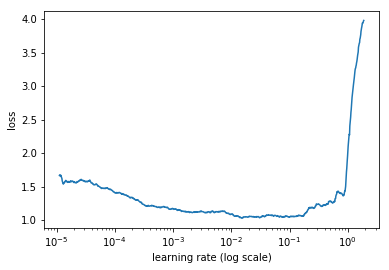

In [46]:
%matplotlib inline
learn.sched.plot()

In [58]:
#learn.crit = F.mse_loss
lr = 0.01
learn.fit(lr, 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      0.755162   0.794928  



[0.79492795]